## Validated boundaries to government unit incident density comparison

The backing theory for this notebook is proving that we will be able to use the highest-density (fire count vs government unit area) government unit to determine a department's boundary for departments that do not have boundaries.

In [1]:
import psycopg2
from psycopg2.extras import RealDictCursor
import pandas as pd
import pdb
# import geopandas as gpd
# from shapely import wkb
# from shapely.geometry import mapping as to_geojson
# import folium

pd.options.display.max_columns = None
pd.options.display.max_rows = None
#pd.set_option('display.float_format', lambda x: '%.3f' % x)

%matplotlib inline

In [2]:
# conn = psycopg2.connect('service=firecares')
nfirs = psycopg2.connect('service=nfirs')

### DB migration/setup

In [9]:
# Create materialized view of all usgs govt units in FireCARES

q = """
create materialized view if not exists usgs_governmentunits as
(
    select id, county_name as name, 'countyorequivalent' as source, geom from usgs_countyorequivalent where geom is not null
    union
    select id, place_name as name, 'incorporatedplace' as source, geom from usgs_incorporatedplace where geom is not null
    union
    select id, minorcivildivision_name as name, 'minorcivildivision' as source, geom from usgs_minorcivildivision where geom is not null
    union
    select id, name, 'nativeamericanarea' as source, geom  from usgs_nativeamericanarea where geom is not null
    union
    select id, name, 'reserve' as source, geom  from usgs_reserve where geom is not null
    union
    select id, state_name as name, 'stateorterritoryhigh' as source, geom from usgs_stateorterritoryhigh where geom is not null
    union
    select id, place_name as name, 'unincorporatedplace' as source, geom from usgs_unincorporatedplace where geom is not null
);

create unique index on usgs_governmentunits (id, source);
create index on usgs_governmentunits using gist (geom);
"""
    
with conn.cursor() as c:
    c.execute(q)
    
conn.commit()

NameError: name 'conn' is not defined

In [10]:
# Link remote firecares usgs_governmentunits view to nfirs-local usgs_government units

q = """
create foreign table usgs_governmentunits (id integer, name character varying(120), source text, geom geometry)
server firecares
options (table_name 'usgs_governmentunits');
"""

with nfirs.cursor() as c:
    c.execute(q)
    
nfirs.commit()

InternalError: current transaction is aborted, commands ignored until end of transaction block


In [5]:
# Old nfirs.firestation_firedepartment foreign table columns needed to be synced

q = """
alter foreign TABLE firestation_firedepartment add column archived boolean NOT NULL;
alter foreign TABLE firestation_firedepartment add column domain_name character varying(255);
alter foreign TABLE firestation_firedepartment add column owned_tracts_geom public.geometry(MultiPolygon,4326);
alter foreign TABLE firestation_firedepartment add column display_metrics boolean NOT NULL;
alter foreign TABLE firestation_firedepartment add column boundary_verified boolean NOT NULL;
alter foreign TABLE firestation_firedepartment add column cfai_accredited boolean NOT NULL;
alter foreign TABLE firestation_firedepartment add column ems_transport boolean NOT NULL;
alter foreign TABLE firestation_firedepartment add column staffing_verified boolean NOT NULL;
alter foreign TABLE firestation_firedepartment add column stations_verified boolean NOT NULL;
alter foreign TABLE firestation_firedepartment add column census_override boolean NOT NULL;
alter foreign TABLE firestation_firedepartment add column additional_fdids character varying(255);
"""

with nfirs.cursor() as c:
    c.execute(q)
nfirs.commit()

InternalError: current transaction is aborted, commands ignored until end of transaction block


In [18]:
q = """
create foreign table if not exists firecares_core_address (id integer NOT NULL,
    address_line1 character varying(100) NOT NULL,
    address_line2 character varying(100),
    city character varying(50) NOT NULL,
    state_province character varying(40) NOT NULL,
    postal_code character varying(10) NOT NULL,
    geom public.geometry(Point,4326),
    geocode_results text,
    country_id character varying(2) NOT NULL)
server firecares
options (table_name 'firecares_core_address');
"""

with nfirs.cursor() as c:
    c.execute(q)
nfirs.commit()

InternalError: current transaction is aborted, commands ignored until end of transaction block


### Processing

In [38]:
q = """
select id, fdid, state, name
from firestation_firedepartment
where boundary_verified = true;
"""

with nfirs.cursor(cursor_factory=RealDictCursor) as c:
    c.execute(q)
    fds = c.fetchall()
    
df = pd.read_pickle('avg_dist')
for i,fd in enumerate(fds):
    try:
        fds[i]['mean_dist'] =df[(df['fdid']==fd['fdid']) & (df['state']==fd['state'])]['mean_dist'].values[0]
    except:
        fds[i]['mean_dist'] = 100.0
        
fds = sorted(fds, key=lambda k: k['mean_dist']) 

In [39]:
q = """
with fires as (select * from joint_buildingfires
    inner join joint_incidentaddress
    using (fdid, inc_no, inc_date, state, exp_no)
    where state = %(state)s and fdid = %(fdid)s AND NOT (AID =  '3' OR AID = '4')
),
govt_units as (
    select gu.name, gu.source, gu.id, gu.geom, fd.id as fc_id, fd.geom as fd_geom, ST_Distance(addr.geom, ST_Centroid(gu.geom)) as distance_to_headquarters
    from firestation_firedepartment fd
    inner join firecares_core_address addr
        on addr.id = fd.headquarters_address_id
    join usgs_governmentunits gu
    on ST_Intersects(ST_Buffer(addr.geom, 0.05), gu.geom)
    where 
        fd.fdid = %(fdid)s and fd.state = %(state)s and source != 'stateorterritoryhigh'
    )
select gu.fc_id, count(fires) / ST_Area(gu.geom) as density, count(fires), ST_Area(ST_SymDifference(gu.fd_geom, gu.geom)) / ST_Area(gu.fd_geom) as percent_difference_to_verified_boundary, ST_Area(gu.geom), gu.distance_to_headquarters, gu.name, gu.id, gu.source from fires
inner join govt_units gu
on ST_Intersects(fires.geom, gu.geom)
group by gu.name, gu.id, gu.geom, gu.source, gu.distance_to_headquarters, gu.fd_geom, gu.fc_id
order by ST_Area(gu.geom) / count(fires) asc;
"""

for fd in fds:
    with nfirs.cursor(cursor_factory=RealDictCursor) as c:
        print 'Analyzing: {} (id: {} fdid: {} {})'.format(fd['name'], fd['id'], fd['fdid'], fd['state'])
        c.execute(q, dict(fdid=fd['fdid'], state=fd['state']))
        items = c.fetchall()
        df = pd.DataFrame(items)
        df.to_csv('./boundary-analysis-{}.csv'.format(fd['id']))

Analyzing: Larchmont Fire Department (id: 86361 fdid: 60025 NY)
Analyzing: Lancaster City Bureau of Fire (id: 86287 fdid: 36064 PA)
Analyzing: City of Somerville Fire Deparment (id: 77887 fdid: 17274 MA)
Analyzing: Haines City Fire Department (id: 83388 fdid: 05042 FL)
Analyzing: Clayton Fire Department (id: 78074 fdid: 09525 MO)
Analyzing: Claremore Fire Department (id: 77971 fdid: 66003 OK)
Analyzing: Fall River Fire Department (id: 81258 fdid: 05095 MA)
Analyzing: Bristol Fire Department (id: 75808 fdid: 52000 VA)
Analyzing: Marshfield Fire and Rescue Department (id: 87956 fdid: 71130 WI)
Analyzing: City of Champaign Fire Department (id: 77599 fdid: CD131 IL)
Analyzing: Petersburg Fire  Rescue and Emergency Services (id: 91878 fdid: 73000 VA)
Analyzing: Vallejo Fire Department (id: 97886 fdid: 48070 CA)
Analyzing: Twinsburg Fire Department (id: 97577 fdid: 77051 OH)
Analyzing: Thomasville Fire Rescue (id: 96872 fdid: 13607 GA)
Analyzing: Collinsville Fire Department (id: 78423 fdid:

### Results

In [40]:
from glob import glob

In [41]:
df = None
for f in glob("boundary-analysis*.csv"):
    if df is not None:
        df = df.append(pd.read_csv(f))
    else:
        df = pd.read_csv(f)

In [42]:
df.rename(columns={'Unnamed: 0': 'rank'}, inplace=True)
selected_government_units = df[df['rank'] == 0].set_index('fc_id')
total_validated_department_count = len(selected_government_units)
perfect_fits = len(selected_government_units[selected_government_units['percent_difference_to_verified_boundary'] == 0])

In [43]:
print 'Perfect fits: {}/{} ({:.2%})'.format(perfect_fits, total_validated_department_count, float(perfect_fits) / total_validated_department_count)
print 'Machine-selected government unit area difference mean: {:.2%}'.format(df[df['rank'] == 0].percent_difference_to_verified_boundary.mean())

Perfect fits: 25/77 (32.47%)
Machine-selected government unit area difference mean: 69.10%


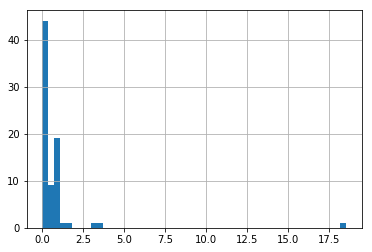

In [44]:
selected_government_units['percent_difference_to_verified_boundary'].hist(bins=50)

In [45]:
selected_government_units

rank   count        density  distance_to_headquarters       id  \
fc_id                                                                    
73310.0    0   767.0  147143.347114                  0.012786  13076.0   
73375.0    0   487.0  117226.959850                  0.039507    962.0   
74286.0    0  7459.0  299610.202417                  0.010716    764.0   
74867.0    0    83.0   48014.754997                  0.009581  31385.0   
74913.0    0    17.0   10993.465002                  0.022096   4268.0   
75808.0    0   413.0  120345.874485                  0.029862   1039.0   
76888.0    0    17.0     383.072382                  0.138564  46483.0   
76924.0    0   207.0   35573.003571                  0.017598  14604.0   
76927.0    0  1251.0   61706.609379                  0.022190   2402.0   
77030.0    0    29.0    1659.108357                  0.108231  16221.0   
77197.0    0  5772.0   74189.876612                  0.022302  28860.0   
77263.0    0   228.0   34765.445609                  0.011000   1299.0   
77286.0    0    58.0   34337.398125                  0.027801   5616.0   
77563.0    0   221.0   44018.694737                  0.016071  36694.0   
77599.0    0   621.0  100428.175657                  0.027382  35516.0   
77887.0    0   492.0  411712.758527                  0.010133   2042.0   
77971.0    0   174.0   44497.445626                  0.003224  12235.0   
77989.0    0   308.0  273562.998430                  0.030587   1954.0   
78074.0    0    65.0   97933.514700                  0.008745  18638.0   
78400.0    0   401.0   52205.082374                  0.060030  46465.0   
78423.0    0   292.0   73221.399628                  0.020073   4999.0   
78578.0    0   372.0   19210.181569                  0.018676  18456.0   
78792.0    0  3067.0   36616.371421                  0.094370  45799.0   
78801.0    0   585.0   99716.978516                  0.011408  11589.0   
78827.0    0   126.0   11165.623937                  0.052474   6574.0   
78884.0    0     3.0    6245.294723                  0.014198   9026.0   
79600.0    0   278.0  107020.055328                  0.027164   2434.0   
79671.0    0  1894.0  230033.036127                  0.092844  10570.0   
80460.0    0   702.0   79309.854459                  0.002641  38261.0   
81083.0    0    55.0   62330.674745                  0.013787   3714.0   
81134.0    0   572.0   35931.287606                  0.070830   9263.0   
81159.0    0   331.0   37952.187544                  0.040709  35587.0   
81163.0    0   149.0   14851.169743                  0.004371   4924.0   
81258.0    0  1600.0  141880.735351                  0.026199   2560.0   
81531.0    0    29.0    1254.014221                  0.068297   7956.0   
81599.0    0   517.0   77056.331484                  0.031957   5164.0   
81646.0    0    24.0    3683.634692                  0.019080   6573.0   
81727.0    0   107.0   65950.416117                  0.076698   6626.0   
82342.0    0   100.0  129837.644744                  0.044383   5062.0   
83122.0    0    19.0    5772.177368                  0.024143   9569.0   
83153.0    0  1565.0  144147.869234                  0.037916  30370.0   
83388.0    0   190.0   40301.937746                  0.006925   8059.0   
83442.0    0   387.0   41660.471964                  0.029491  43286.0   
84012.0    0   265.0   25978.706569                  0.019475  31131.0   
84030.0    0     4.0    1898.144305                  0.008800   3585.0   
85026.0    0     3.0   22941.311075                  0.007315   5560.0   
85372.0    0    51.0   71966.007119                  0.019106   6366.0   
86287.0    0   375.0  186597.718720                  0.007590  17056.0   
86361.0    0   106.0  354716.218751                  0.002133  17500.0   
86381.0    0  3123.0   88533.359291                  0.132850  18787.0   
87956.0    0   109.0   31956.376680                  0.003401  46155.0   
88441.0    0     2.0  242248.355439                  0.044803  38006.0   
88510.0    0

In [8]:
df.set_index('fc_id')

rank  count        density  distance_to_headquarters     id  \
fc_id                                                                
78801     0    585   99716.978516                  0.011408  11589   
78801     1    617    6956.982835                  0.049155  40009   
78801     2    620    2308.610455                  0.046837   2605   
85026     0      3   22941.311075                  0.007315   5560   
85026     1      3      86.923032                  0.015528  36080   
85026     2      3      11.288303                  0.393362   2521   
78578     0    372   19210.181569                  0.018676  18456   
78578     1    372   19210.181569                  0.018676  30145   
78578     2    373    1357.456627                  0.156079   1813   
77887     0    492  411712.758527                  0.010133   2042   
77887     1    492  411712.758527                  0.010133   1517   
77887     2     12    5964.478376                  0.031102   2027   
77887     3     12    5964.478376                  0.031102   2016   
77887     4    506    2106.446964                  0.315218   2244   
77887     5      2     815.332877                  0.036952   1539   
77887     6      2     815.332877                  0.036952   1722   
77887     7      1      39.432999                  0.095002   1564   
77887     8      1      39.432999                  0.095002   2402   
77887     9      1      29.395339                  0.113664   1712   
83442     0    387   41660.471964                  0.029491  43286   
83442     1    444    1848.318459                  0.081168   2282   
83442     2      3     509.609601                  0.083484   1128   
83442     3      3     509.609601                  0.083484  43250   
83442     4      1     166.779401                  0.064188  35740   
83442     5      1     107.262109                  0.090355  36054   
83442     6      1      89.860200                  0.129566  43829   
81727     0    107   65950.416117                  0.076698   6626   
81727     1    564   19095.228686                  0.072461  42689   
81727     2   1009   16109.539393                  0.056274   1468   
81727     3    133   11345.180412                  0.063114  42688   
81727     4    100    9823.683918                  0.088605  42690   
81531     0     29    1254.014221                  0.068297   7956   
81531     1    106     770.831161                  0.047294   2591   
81531     2     75     699.235919                  0.088284  42121   
81531     3     23     688.903639                  0.093834   7957   
78792     0   3067   36616.371421                  0.094370  45799   
78792     1   3154   27174.119424                  0.149747  14022   
78792     2   3180   11509.122911                  0.116860   3171   
78792     3     70     969.215515                  0.225959  45780   
89555     0    121   35694.222690                  0.017323  13985   
89555     1     35   21492.711615                  0.052182  13192   
89555     2      9    3008.346095                  0.059993  13173   
89555     3    197    2193.350754                  0.034171  36344   
89555     4      7    1858.352424                  0.065920   3079   
89555     5    206     925.023140                  0.033858   2428   
89555     6      2     916.002913                  0.067270  13191   
89555     7     18     583.118099                  0.118310  13987   
89555     8      2     223.613326                  0.128260  13174   
79671     0   1894  230033.036127                  0.092844  10570   
79671     1   1391  193364.143301                  0.006304   8786   
79671     2   3876  152771.061951                  0.049763   1160   
79671     3    485   61414.315009                  0.120182  11100   
79671     4   3888   23466.949955                  0.095099   1543   
79671     5     15    3475.138046                  0.094185   8819   
79671     6     15    3008.289264                  0.068737  11122   
79671     7      

In [9]:
df.to_csv('./validated-boundary-vs-government-unit-density.csv')

In [11]:
pd.read_csv('./validated-boundary-vs-government-unit-density.csv')

Unnamed: 0  rank  count        density  distance_to_headquarters  fc_id  \
0             0     0    585   99716.978516                  0.011408  78801   
1             1     1    617    6956.982835                  0.049155  78801   
2             2     2    620    2308.610455                  0.046837  78801   
3             0     0      3   22941.311075                  0.007315  85026   
4             1     1      3      86.923032                  0.015528  85026   
5             2     2      3      11.288303                  0.393362  85026   
6             0     0    372   19210.181569                  0.018676  78578   
7             1     1    372   19210.181569                  0.018676  78578   
8             2     2    373    1357.456627                  0.156079  78578   
9             0     0    492  411712.758527                  0.010133  77887   
10            1     1    492  411712.758527                  0.010133  77887   
11            2     2     12    5964.478376                  0.031102  77887   
12            3     3     12    5964.478376                  0.031102  77887   
13            4     4    506    2106.446964                  0.315218  77887   
14            5     5      2     815.332877                  0.036952  77887   
15            6     6      2     815.332877                  0.036952  77887   
16            7     7      1      39.432999                  0.095002  77887   
17            8     8      1      39.432999                  0.095002  77887   
18            9     9      1      29.395339                  0.113664  77887   
19            0     0    387   41660.471964                  0.029491  83442   
20            1     1    444    1848.318459                  0.081168  83442   
21            2     2      3     509.609601                  0.083484  83442   
22            3     3      3     509.609601                  0.083484  83442   
23            4     4      1     166.779401                  0.064188  83442   
24            5     5      1     107.262109                  0.090355  83442   
25            6     6      1      89.860200                  0.129566  83442   
26            0     0    107   65950.416117                  0.076698  81727   
27            1     1    564   19095.228686                  0.072461  81727   
28            2     2   1009   16109.539393                  0.056274  81727   
29            3     3    133   11345.180412                  0.063114  81727   
30            4     4    100    9823.683918                  0.088605  81727   
31            0     0     29    1254.014221                  0.068297  81531   
32            1     1    106     770.831161                  0.047294  81531   
33            2     2     75     699.235919                  0.088284  81531   
34            3     3     23     688.903639                  0.093834  81531   
35            0     0   3067   36616.371421                  0.094370  78792   
36            1     1   3154   27174.119424                  0.149747  78792   
37            2     2   3180   11509.122911                  0.116860  78792   
38            3     3     70     969.215515                  0.225959  78792   
39            0     0    121   35694.222690                  0.017323  89555   
40            1     1     35   21492.711615                  0.052182  89555   
41            2     2      9    3008.346095                  0.059993  89555   
42            3     3    197    2193.350754                  0.034171  89555   
43            4     4      7    1858.352424                  0.065920  89555   
44            5     5    206     925.023140                  0.033858  89555   
45            6     6      2     916.002913                  0.067270  89555   
46            7     7     18     583.118099                  0.118310  89555   
47            8     8      2     223.613326                  0.128260  89555   
48            0     0   1894  230033.036127                  0.092844  79671   
49   